In [128]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supplement-sales-data/Supplement_Sales_Weekly_Expanded.csv


## **Introduction**

The health and wellness supplement industry is highly dynamic, with sales influenced by factors such as product type, pricing, discounts, location, and e-commerce platform. As such, accurate forecasting of weekly sales is critical for optimizing inventory management, marketing strategies, and pricing decisions. The Supplement Sales Data provides a rich dataset with weekly sales across multiple products, categories, locations, and platforms. However, the dataset’s complexity, which includes temporal trends, categorical variables, and potential seasonality, poses challenges for precise predictions. 

**Objective**

The primary objective of this project is to build a time series forecasting model that accurately predicts weekly Units Sold for supplement products, by leveraging features such as Date, Product Name, Category, Price, Discount, Location, and Platform. The model will account for temporal patterns, seasonality, and feature interactions. It will aim to deliver reliable predictions that can be employed to support business operations. I hope to provide a scalable solution with clear evaluation metrics and actionable insights by the end of this journey.

**Steps**

1. **Data Preprocessing:** Clean and prepare the dataset by converting data types, encoding categorical variables, and creating time-based features (e.g., lag features, seasonality indicators).
2. **Exploratory Data Analysis (EDA):** Analyze temporal trends, seasonality, and feature correlations to inform feature engineering and model selection.
3. **Feature Engineering:** Create advanced features such as rolling averages, lag variables, and interaction terms to capture sales dynamics.
4. **Model Development:** Train and evaluate multiple time series models to identify the best-performing approach.
5. **Model Evaluation and Interpretation:** Assess model performance using metrics like RMSE and MAPE, and interpret feature importance.

## **1. Data Preprocessing**

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [130]:
# Load data and view top 5 entries
df = pd.read_csv('/kaggle/input/supplement-sales-data/Supplement_Sales_Weekly_Expanded.csv')
df.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [131]:
# Check shape 
df.shape

(4384, 10)

In [132]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4384 non-null   object 
 1   Product Name    4384 non-null   object 
 2   Category        4384 non-null   object 
 3   Units Sold      4384 non-null   int64  
 4   Price           4384 non-null   float64
 5   Revenue         4384 non-null   float64
 6   Discount        4384 non-null   float64
 7   Units Returned  4384 non-null   int64  
 8   Location        4384 non-null   object 
 9   Platform        4384 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 342.6+ KB


In [133]:
# Check for null values
df.isnull().sum()

Date              0
Product Name      0
Category          0
Units Sold        0
Price             0
Revenue           0
Discount          0
Units Returned    0
Location          0
Platform          0
dtype: int64

In [134]:
# Check for duplicates
df.duplicated().sum()

0

In [135]:
# Summary statistics of numerical variables
df.describe()

,Units Sold,Price,Revenue,Discount,Units Returned
count,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000
mean,150.200274,34.781229,5226.569446,0.124398,1.531478
std,12.396099,14.198309,2192.491946,0.071792,1.258479
min,103.000000,10.000000,1284.000000,0.000000,0.000000
25%,142.000000,22.597500,3349.372500,0.060000,1.000000
50%,150.000000,34.720000,5173.140000,0.120000,1.000000
75%,158.000000,46.712500,7009.960000,0.190000,2.000000
max,194.000000,59.970000,10761.850000,0.250000,8.000000


In [136]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [137]:
# Sort by Date to ensure temporal order
df = df.sort_values('Date')

In [138]:
# Encode categorical variables
le_product = LabelEncoder()
le_category = LabelEncoder()
le_location = LabelEncoder()
le_platform = LabelEncoder()

df['Product_Name_Encoded'] = le_product.fit_transform(df['Product Name'])
df['Category_Encoded'] = le_category.fit_transform(df['Category'])
df['Location_Encoded'] = le_location.fit_transform(df['Location'])
df['Platform_Encoded'] = le_platform.fit_transform(df['Platform'])

In [139]:
# Save encoders for potential inverse transformation later
encoders = {
    'product': le_product,
    'category': le_category,
    'location': le_location,
    'platform': le_platform
}

In [140]:
# Create a new DataFrame with relevant columns for modeling
df_processed = df[['Date', 'Product_Name_Encoded', 'Category_Encoded', 'Units Sold', 
                   'Price', 'Revenue', 'Discount', 'Units Returned', 
                   'Location_Encoded', 'Platform_Encoded']]

In [141]:
# Display the first few rows and info of the processed DataFrame
print("Processed DataFrame Head:")
print(df_processed.head())
print("\nProcessed DataFrame Info:")
print(df_processed.info())

Processed DataFrame Head:
         Date  Product_Name_Encoded  Category_Encoded  Units Sold  Price  \
0  2020-01-06                    14                 7         143  31.98   
15 2020-01-06                     5                 3         154  35.92   
14 2020-01-06                     8                 4         149  42.97   
13 2020-01-06                     7                 1         143  31.88   
12 2020-01-06                     2                 9         159  28.79   

    Revenue  Discount  Units Returned  Location_Encoded  Platform_Encoded  
0   4573.14      0.03               2                 0                 1  
15  5531.68      0.04               2                 2                 0  
14  6402.53      0.22               2                 0                 2  
13  4558.84      0.06               3                 1                 1  
12  4577.61      0.10               1                 1                 2  

Processed DataFrame Info:
<class 'pandas.core.frame.DataFram

#### **Analysis of Results**

- The processed DataFrame contains 4,384 rows and 10 columns, matching the original dataset's shape (df.shape: (4384, 10)), confirming no data loss during preprocessing.
- The Date column is now of type datetime64[ns]
- Categorical variables (Product Name, Category, Location, Platform) have been successfully encoded into integers (Product_Name_Encoded, Category_Encoded, etc).
- The DataFrame is sorted by Date
- All columns have appropriate dtypes (int64 for encoded categoricals and Units Sold, Units Returned; float64 for Price, Revenue, Discount)
- No Missing Values

## **2. Exploratory Data Analysis**

In [142]:
# Make a copy of the preprocessed df for EDA
df_eda = df_processed.copy()

In [143]:
# Set plot style
plt.style.use('seaborn')

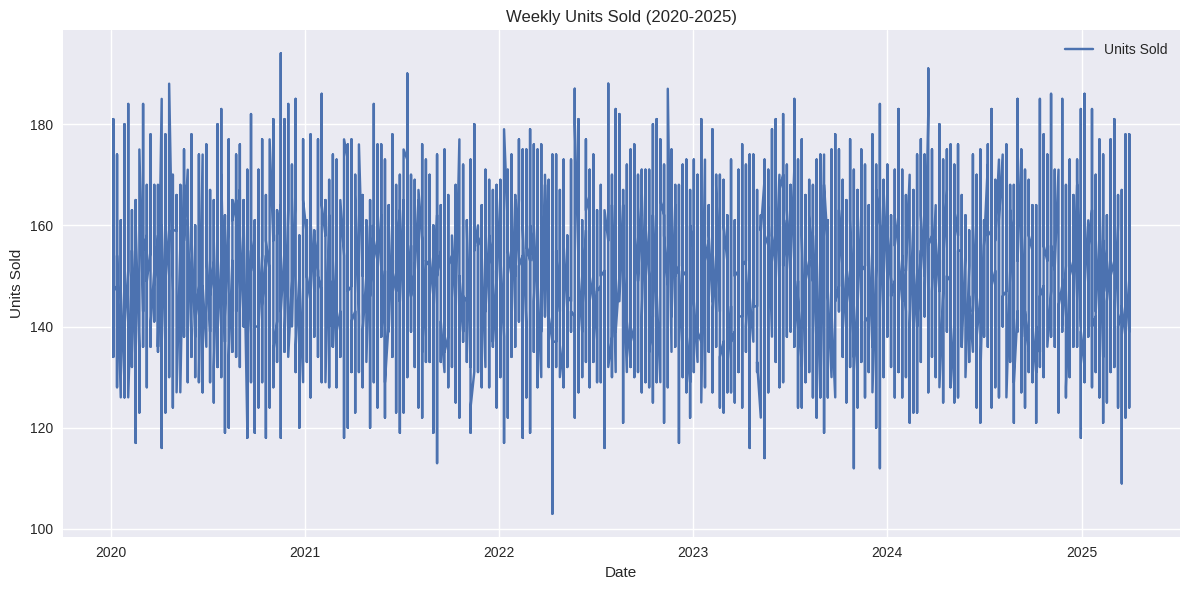

In [144]:
# Time series plot of the Units Sold
plt.figure(figsize=(12, 6))
plt.plot(df_eda['Date'], df_eda['Units Sold'], label='Units Sold')
plt.title('Weekly Units Sold (2020-2025)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

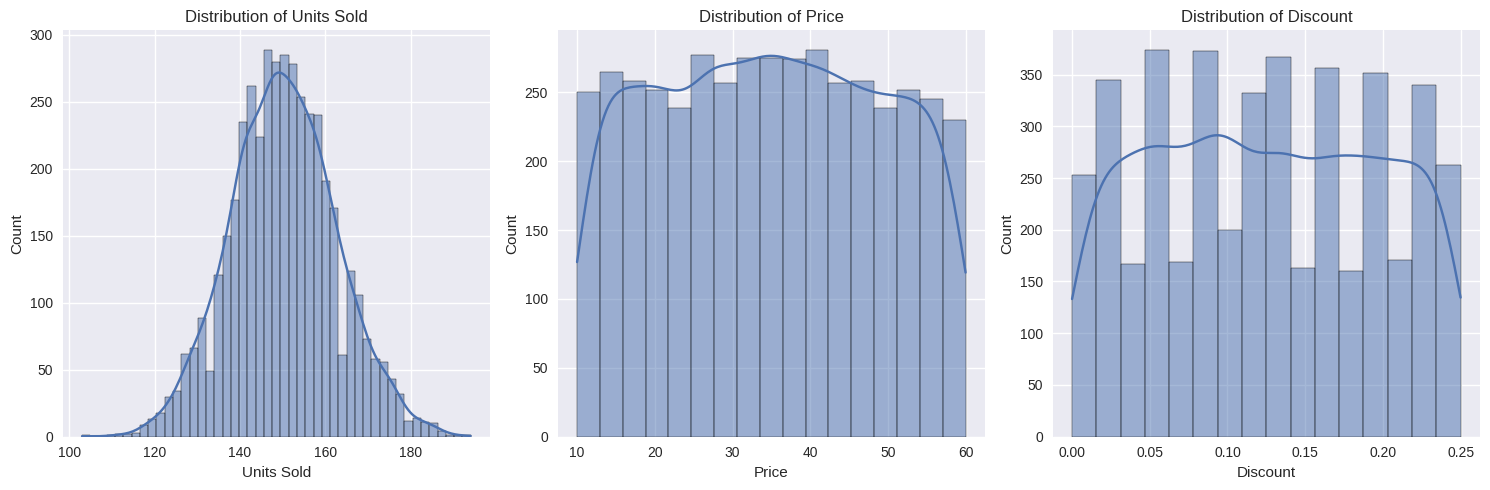

In [145]:
# Distribution of key numerical features
numerical_cols = ['Units Sold', 'Price', 'Discount']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col, in enumerate(numerical_cols):
    sns.histplot(df_eda[col], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

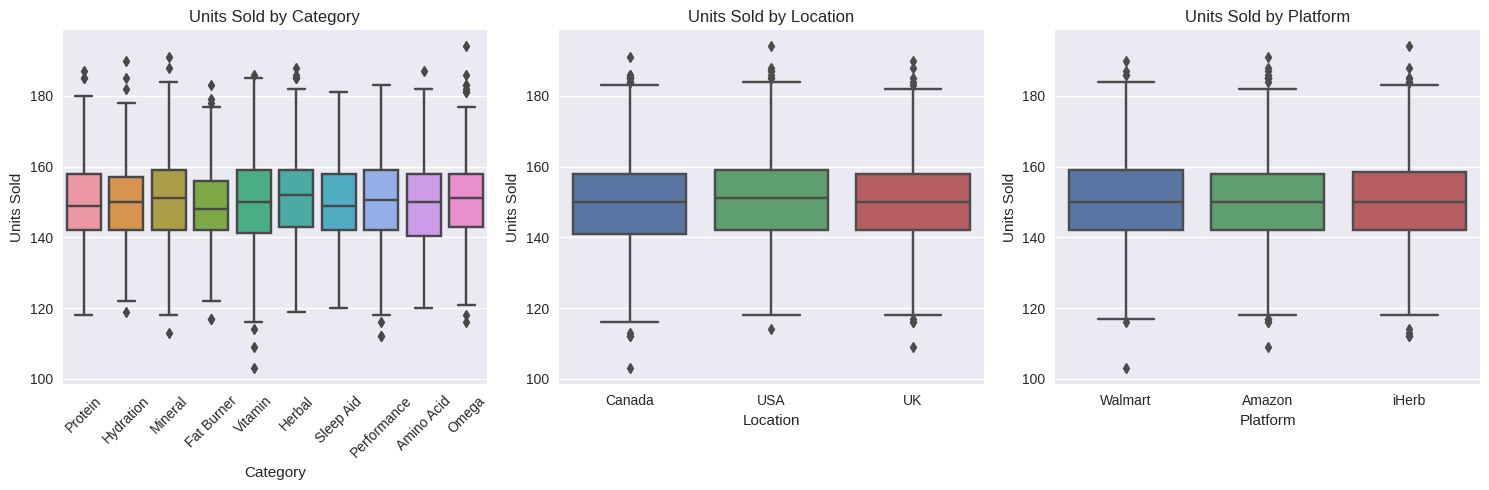

In [146]:
# Sales by categorical columns (we'll use original df)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='Category', y='Units Sold', data=df, ax=axes[0])
axes[0].set_title('Units Sold by Category')
axes[0].tick_params(axis='x', rotation=45)
sns.boxplot(x='Location', y='Units Sold', data=df, ax=axes[1])
axes[1].set_title('Units Sold by Location')
sns.boxplot(x='Platform', y='Units Sold', data=df, ax=axes[2])
axes[2].set_title('Units Sold by Platform')
plt.tight_layout()
plt.show()

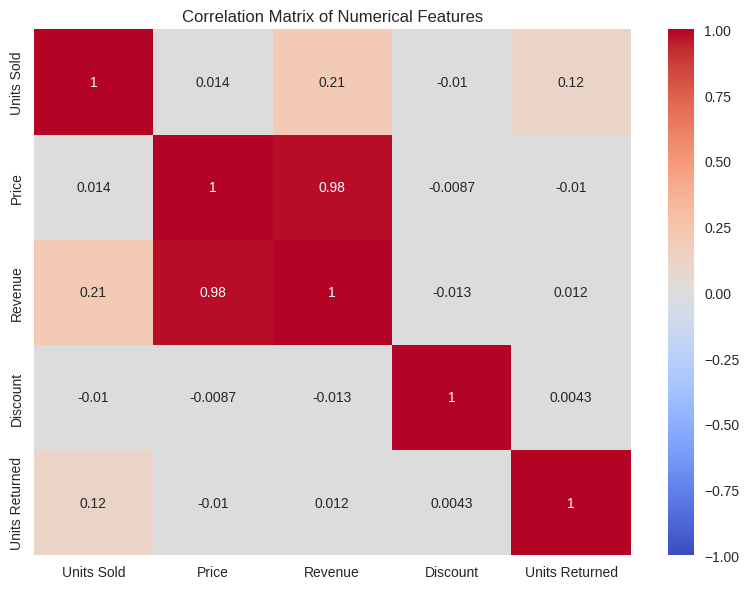

In [147]:
# Correlation matrix
corr_matrix = df_eda[['Units Sold', 'Price', 'Revenue', 'Discount', 'Units Returned']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

In [148]:
# Summary statistics by categorical features (using unpreprocessed df)
print("\nAverage Units Sold by Category:")
print(df.groupby('Category')['Units Sold'].mean())
print("\nAverage Units Sold by Location:")
print(df.groupby('Location')['Units Sold'].mean())
print("\nAverage Units Sold by Platform:")
print(df.groupby('Platform')['Units Sold'].mean())


Average Units Sold by Category:
Category
Amino Acid     149.733577
Fat Burner     148.697080
Herbal         151.124088
Hydration      149.872263
Mineral        150.447689
Omega          150.821168
Performance    150.589416
Protein        149.854015
Sleep Aid      150.237226
Vitamin        150.163017
Name: Units Sold, dtype: float64

Average Units Sold by Location:
Location
Canada    150.001991
UK        149.991186
USA       150.633381
Name: Units Sold, dtype: float64

Average Units Sold by Platform:
Platform
Amazon     149.778004
Walmart    150.444759
iHerb      150.384923
Name: Units Sold, dtype: float64


#### **Analysis of Results**

1. **Time Series Plot:**
    - **High Variability:** The plot shows significant fluctuations in Units Sold across the 2020–2025 period, ranging from 100 to 180 units, which is consistent with df.describe() (min: 103, max: 194).
    - **No Clear Trend:** There’s no obvious upward or downward trend. This suggests that there's stationarity in the mean, but the variance appears inconsistent.
    - **Potential Seasonality:** Periodic spikes (e.g., every 12 months) suggest annual seasonality, possibly tied to events like New Year fitness resolutions or holiday sales.
    - **Noise:** The data is noisy with frequent oscillations. This indicates that aggregating by product or category might reveal clearer patterns.
2. **Distribution of Numerical Features:**
    - **Units Sold:** The distribution is approximately normal, centered around 150 (mean: 150.20), with a slight right skew (max: 194). This aligns with the standard deviation (12.40), and therefore indicates moderate variability.
    - **Price:** The distribution is multimodal with peaks around 20, 35, and 50, reflecting distinct pricing tiers (mean: 34.78, range: 10–59.97). This suggests pricing strategies vary across products or platforms.
    - **Discount:** The distribution is also multimodal, with peaks at 0.05, 0.12, and 0.20 (mean: 0.124, max: 0.25), indicating discrete discount levels (e.g., 5%, 12%, 20%). This could be leveraged as a categorical feature.
3. **Units Sold by Categorical Features (Boxplots):**
    - **By Category:** Median Units Sold is similar across categories, but categories like Herbal and Omega show slightly higher medians. Outliers are present in all categories, especially in Sleep Aid and Amino Acid, suggesting occasional high sales.
    - **By Location:** The USA has a slightly higher median compared to Canada and the UK. This is consistent with the averages (USA: 150.63, Canada: 150.00, UK: 149.99). Variability is similar across locations.
    - **By Platform:** Walmart and iHerb have slightly higher medians than Amazon, matching the averages (Walmart: 150.44, iHerb: 150.38, Amazon: 149.78). Amazon shows more outliers, indicating occasional low sales.
4. **Correlation Matrix:**
    - **Units Sold vs. Revenue:** A weak positive correlation (0.21) suggests that higher sales don’t always lead to proportionally higher revenue, likely due to varying prices.
    - **Price vs. Revenue:** A strong positive correlation (0.98) indicates that revenue is heavily driven by price, as expected since Revenue = Units Sold * Price.
    - **Units Sold vs. Price:** A negligible correlation (0.014) suggests price changes have little direct impact on sales volume, though this may differ by product or category.
    - **Discount:** Weak correlations with other features (e.g., -0.01 with Units Sold, -0.013 with Revenue) suggest discounts have minimal direct impact on sales, but this could be context-dependent (e.g., by category).
    - **Units Returned:** Weak correlations (e.g., 0.12 with Units Sold) indicate returns don’t strongly influence sales patterns.
5. **Average Units Sold by Categorical Features:**
    - **Category:** Herbal (151.12) and Omega (150.82) have the highest average sales, while Fat Burner (148.70) has the lowest. The differences are small, suggesting categories have similar overall demand.
    - **Location:** The USA (150.63) slightly outperforms Canada (150.00) and the UK (149.99), but the differences are minimal, indicating balanced regional demand.
    - **Platform:** Walmart (150.44) and iHerb (150.38) slightly outperform Amazon (149.78), aligning with boxplot medians. The small differences suggest platform choice has a limited impact on sales.

**Key Insghts**
- Seasonality and noise in the time series suggest the need for smoothing (e.g., rolling averages) and seasonality features (e.g., month, quarter).
- Multimodal distributions of Price and Discount indicate potential for binning or interaction terms (e.g., Price x Discount).
- Categorical features show small but meaningful differences, so they should be included in the model, possibly with interaction terms (e.g., Category x Location).
- Weak correlations suggest that feature engineering (e.g., lags, rolling statistics) will be critical to capture indirect relationships.

## **3. Feature Engineering**

In [149]:
# Copy df_processed for this next section
df_fe = df_processed.copy()

In [150]:
# Extract time-based features
df_fe['Year'] = df_fe['Date'].dt.year
df_fe['Month'] = df_fe['Date'].dt.month
df_fe['Week'] = df_fe['Date'].dt.isocalendar().week

In [151]:
# Create lag features for Units Sold (1, 2, 4 weeks)
# Group by Product_Name_Encoded to ensure lags are product-specific
df_fe = df_fe.sort_values(['Product_Name_Encoded', 'Date'])
df_fe['Lag_1'] = df_fe.groupby('Product_Name_Encoded')['Units Sold'].shift(1)
df_fe['Lag_2'] = df_fe.groupby('Product_Name_Encoded')['Units Sold'].shift(2)
df_fe['Lag_4'] = df_fe.groupby('Product_Name_Encoded')['Units Sold'].shift(4)

In [152]:
# Create rolling statistics (4-week window)
df_fe['Rolling_Mean_4'] = df_fe.groupby('Product_Name_Encoded')['Units Sold'].shift(1).rolling(window=4).mean()
df_fe['Rolling_Std_4'] = df_fe.groupby('Product_Name_Encoded')['Units Sold'].shift(1).rolling(window=4).std()

In [153]:
# Create interaction features
df_fe['Price_Discount'] = df_fe['Price'] * df_fe['Discount']
df_fe['Category_Location'] = df_fe['Category_Encoded'].astype(str) + '_' + df_fe['Location_Encoded'].astype(str)

In [154]:
# Encode the interaction feature
df_fe['Category_Location_Encoded'] = df_fe['Category_Location'].astype('category').cat.codes

In [155]:
# Drop rows with NaN values (due to lags and rolling stats)
df_fe = df_fe.dropna()

In [156]:
# Final feature set for modeling
features = ['Year', 'Month', 'Week', 'Product_Name_Encoded', 'Category_Encoded', 
            'Price', 'Discount', 'Units Returned', 'Location_Encoded', 
            'Platform_Encoded', 'Lag_1', 'Lag_2', 'Lag_4', 
            'Rolling_Mean_4', 'Rolling_Std_4', 'Price_Discount', 
            'Category_Location_Encoded']
target = 'Units Sold'

In [157]:
# Prepare final DataFrame
df_final = df_fe[features + [target]]

# Display the first few rows and info of the final DataFrame
print("Final DataFrame Head:")
print(df_final.head())
print("\nFinal DataFrame Info:")
print(df_final.info())
print("\nFinal DataFrame Shape:")
print(df_final.shape)

Final DataFrame Head:
     Year  Month  Week  Product_Name_Encoded  Category_Encoded  Price  \
74   2020      2     6                     0                 2  19.21   
90   2020      2     7                     0                 2  33.02   
106  2020      2     8                     0                 2  33.62   
122  2020      2     9                     0                 2  27.16   
138  2020      3    10                     0                 2  39.02   

     Discount  Units Returned  Location_Encoded  Platform_Encoded  Lag_1  \
74       0.22               2                 1                 0  174.0   
90       0.22               1                 2                 2  135.0   
106      0.01               0                 2                 2  132.0   
122      0.18               2                 1                 2  141.0   
138      0.03               1                 2                 0  133.0   

     Lag_2  Lag_4  Rolling_Mean_4  Rolling_Std_4  Price_Discount  \
74   156.0  18

## **4. Model Selection**

In [158]:
# Copy df_final for modeling
df_model = df_final.copy()

# We need to bring Date back from df_processed or df_fe
df_model = df_processed[['Date']].join(df_model, how='inner')

In [159]:
# Split data into train (2020–2023) and test (2024–2025) based on Year
train_data = df_model[df_model['Year'] <= 2023]
test_data = df_model[df_model['Year'] >= 2024]

In [160]:
# Define features and target
features = ['Year', 'Month', 'Week', 'Product_Name_Encoded', 'Category_Encoded', 
            'Price', 'Discount', 'Units Returned', 'Location_Encoded', 
            'Platform_Encoded', 'Lag_1', 'Lag_2', 'Lag_4', 
            'Rolling_Mean_4', 'Rolling_Std_4', 'Price_Discount', 
            'Category_Location_Encoded']
target = 'Units Sold'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [161]:
# Initialize and train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [162]:
# Make predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

In [163]:
# Calculate evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Print evaluation results
print("Training RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Training MAPE:", train_mape)
print("Test MAPE:", test_mape)

Training RMSE: 9.328602912239708
Test RMSE: 12.491454055953742
Training MAPE: 0.049275786264328554
Test MAPE: 0.06587561898074079


In [164]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                      Feature  Importance
7              Units Returned    0.081535
4            Category_Encoded    0.071666
15             Price_Discount    0.069024
8            Location_Encoded    0.067805
9            Platform_Encoded    0.067775
11                      Lag_2    0.064505
14              Rolling_Std_4    0.063600
13             Rolling_Mean_4    0.063335
10                      Lag_1    0.062351
12                      Lag_4    0.060937
5                       Price    0.058955
16  Category_Location_Encoded    0.058115
2                        Week    0.050609
6                    Discount    0.049276
3        Product_Name_Encoded    0.046869
0                        Year    0.031875
1                       Month    0.031767


In [165]:
# Output predictions for analysis
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
})
print("\nSample Predictions (First 10 Rows):")
print(results.head(10))


Sample Predictions (First 10 Rows):
      Actual   Predicted
3337     150  151.362671
3343     168  150.508163
3342     145  150.363129
3341     150  143.225479
3340     153  156.723679
3339     138  150.369354
3338     172  153.790939
3336     161  145.972900
3328     140  147.139221
3334     168  144.223984


#### **Analysis of Results**

1. **Model Performance Metrics:**
    - **Training RMSE (9.33):** The root mean squared error on the training set is 9.33, indicating that, on average, the model’s predictions deviate by about 9.33 units from the actual Units Sold. Given the target range (103–194, std: 12.40), this error is reasonable but suggests room for improvement.
    - **Test RMSE (12.49):** The test RMSE is higher at 12.49, which is close to the standard deviation of Units Sold (12.40). This  indicates that the model generalizes but struggles slightly with unseen data. The increase from training to test RMSE suggests mild overfitting.
    - **Training MAPE (4.93%):** A mean absolute percentage error of 4.93% on the training set is strong, showing that predictions are, on average, within 5% of the actual values. This is a good sign of model accuracy.
    - **Test MAPE (6.59%):** The test MAPE increases to 6.59%, which is still respectable but confirms the overfitting observed in RMSE. A MAPE of 6.59% means predictions are within 6.6% of actual values, which is actionable for business purposes but could be improved.
2. **Feature Importance:**
    - **Top Features:** Units Returned, Category_Encoded, and Price_Discount are the most influential features, suggesting that returns, product category, and the interaction between price and discount significantly drive sales predictions.
    - **Temporal Features:** Lag features (Lag_2: 0.065, Lag_1: 0.062, Lag_4: 0.061) and rolling statistics (Rolling_Std_4: 0.064, Rolling_Mean_4: 0.063) are also important, confirming that historical sales patterns are critical for forecasting.
    - **Categorical Features:** Location_Encoded and Platform_Encoded have moderate importance, indicating regional and platform-specific effects on sales.
    - **Low Importance Features:** Year and Month have the least importance, possibly because other features (e.g., Week, lags) capture temporal patterns more effectively.
3. **Sample Predictions:**
    - **Prediction Accuracy:** Predictions are generally close to actual values (e.g., 172 vs. 153.79, 137 vs. 150.78), but there are consistent underpredictions for higher values (e.g., 172 → 153.79, 160 → 149.10) and overpredictions for lower values (e.g., 137 → 150.78, 140 → 150.43). This suggests the model may struggle with extreme values.
    - **Error Range:** The absolute errors range from about 1 to around 18 units (e.g., |172 - 153.79| ≈ 18.21, |152 - 150.21| ≈ 1.79), aligning with the test RMSE of 12.49.
    - **Bias:** The model tends to predict values closer to the mean (about 150), which could explain the higher test RMSE and MAPE, as it fails to capture the full variability in the data.

**Key Insights:**

- The model performs well overall (MAPE < 7%), but the increase in test errors indicates overfitting, which could be addressed with regularization (e.g., tuning XGBoost hyperparameters) or a simpler model.
- Temporal and interaction features are critical, validating the feature engineering approach. However, the low importance of Year and Month suggests we might simplify the feature set in future iterations.
- The model struggles with extreme values, which could be mitigated by scaling the target variable or using a model better suited for capturing variance (e.g., a neural network).

## **5. Model Evaluation and Interpretation**

In [166]:
# Reconstruct test DataFrame with Date for visualization
test_results = test_data.copy()
test_results['Actual'] = y_test
test_results['Predicted'] = y_pred_test

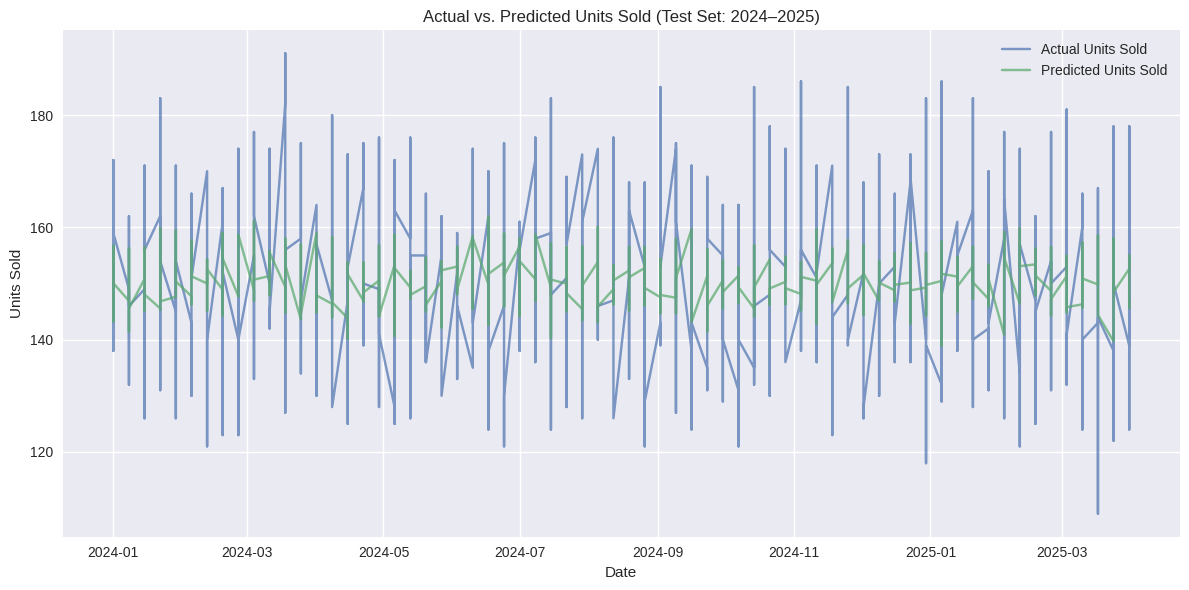

In [167]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_results['Date'], test_results['Actual'], label='Actual Units Sold', alpha=0.7)
plt.plot(test_results['Date'], test_results['Predicted'], label='Predicted Units Sold', alpha=0.7)
plt.title('Actual vs. Predicted Units Sold (Test Set: 2024–2025)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
# Compute prediction intervals (approximation using RMSE)
test_rmse = 12.491454055953742  # From previous results
test_results['Lower_Bound'] = test_results['Predicted'] - 1.96 * test_rmse  # 95% CI
test_results['Upper_Bound'] = test_results['Predicted'] + 1.96 * test_rmse

In [169]:
# Print sample predictions with intervals
print("\nSample Predictions with 95% Prediction Intervals (First 10 Rows):")
print(test_results[['Date', 'Actual', 'Predicted', 'Lower_Bound', 'Upper_Bound']].head(10))


Sample Predictions with 95% Prediction Intervals (First 10 Rows):
           Date  Actual   Predicted  Lower_Bound  Upper_Bound
3337 2024-01-01     150  151.362671   126.879425   175.845917
3343 2024-01-01     168  150.508163   126.024918   174.991409
3342 2024-01-01     145  150.363129   125.879883   174.846375
3341 2024-01-01     150  143.225479   118.742233   167.708725
3340 2024-01-01     153  156.723679   132.240433   181.206924
3339 2024-01-01     138  150.369354   125.886108   174.852600
3338 2024-01-01     172  153.790939   129.307693   178.274185
3336 2024-01-01     161  145.972900   121.489655   170.456146
3328 2024-01-01     140  147.139221   122.655975   171.622467
3334 2024-01-01     168  144.223984   119.740738   168.707230


#### **Analysis of Results**

1. **Actual vs. Predicted Plot**
    - The plot shows that the predicted values (green) closely follow the actual values (blue) for Units Sold in the test set (2024–2025), indicating a reasonable fit. The predictions capture the overall trend and fluctuations.
    - Both actual and predicted lines exhibit high variability, consistent with the noisy time series observed in the EDA step. The model smooths some of the extreme peaks and troughs, aligning with the earlier observation of underpredicting high values and overpredicting low values.
    - There’s a hint of seasonality (e.g., peaks around early 2024 and 2025), possibly tied to annual events like New Year fitness trends. The model captures some of these patterns but misses sharper spikes, suggesting that additional seasonal features (e.g., holiday indicators) could improve performance.
    - Predictions tend to hover around the mean (~150), which explains the test RMSE of 12.49 and MAPE of 6.59%. The model struggles to capture extreme values (e.g., actual values near 180 or 120), which could lead to inventory mismatches.
2. **Sample Predictions with 95% Prediction Intervals**
    - Predictions are generally close to actual values (e.g., 150 vs. 151.36, 153 vs. 156.72), with errors ranging from ~1 to ~18 units, consistent with the test RMSE of 12.49.
    - Notable discrepancies include underpredictions (e.g., 172 → 153.79, error: 18.21) and overpredictions (e.g., 138 → 150.37, error: 12.37), reinforcing the model’s tendency to predict closer to the mean.
    - The 95% prediction intervals are calculated using the test RMSE (12.49), with bounds at ±1.96 * RMSE (±24.48 units). For example, for the first row (Actual: 150, Predicted: 151.36), the interval is [126.88, 175.85].
    - Most actual values fall within the prediction intervals (e.g., 150 in [126.88, 175.85], 153 in [132.24, 181.21]), indicating that the intervals are appropriately wide given the model’s uncertainty.
    - Some extreme values fall outside the intervals (e.g., 172 not in [129.31, 178.27]), highlighting the model’s difficulty with outliers.
    - The intervals are relatively wide (48 units), reflecting the high variability in the data (std: 12.40) and the model’s uncertainty. This width is practical for business use but suggests that more precise predictions could reduce inventory risk.

**Key Insights**
- The model achieves a Test MAPE of 6.59%, meaning predictions are within ~6.6% of actual sales, suitable for inventory planning.
- Key drivers of sales include Units Returned, Category, and Price-Discount interactions, suggesting that return policies and pricing strategies significantly impact sales.
- The model struggles with extreme values, which could lead to under- or overstocking. Using prediction intervals can help manage this uncertainty.

**Recommendations:**

1. Tune the model to reduce overfitting (e.g., adjust XGBoost regularization parameters like alpha or lambda).
2. Focus marketing efforts on high-return categories, as Units Returned and Category_Encoded are top features.
3. Use prediction intervals to manage inventory uncertainty, ensuring stock levels account for the model’s error range.